In [1]:
import jax, tqdm
import jax.numpy as jnp
import numpy as np

from jax import grad, value_and_grad
from jax.nn import softmax, log_softmax

from numpyro.optim import Adam

from functools import partial

np.random.seed(123)
np.set_printoptions(suppress=True)

/home/jalko/.conda/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We want to minimize the probability of returning a wrong category under the DP guarantee. We do this by learning utility scores for the exponential mechanism.

In [2]:
lamb = 0.0 # weight for l2 penalty
#bandwidth = .001 # kernel bandwidth


def get_logps(qs, eps):
    n = len(qs)
    sensitivity = jnp.max(jnp.abs(qs[:(n-1)]-qs[1:]))
    
    
    #log_ps = log_softmax(eps / (2.*sensitivities.reshape(-1, 1)) * qs, axis=1)
    log_ps = log_softmax(eps / (2.*sensitivity) * qs, axis=1)
    return log_ps

#cat_edges = [5, 40, 50, 65, 72, 78] # NOTE
def loss(qs, categories, eps):
    n_cats = categories.shape[1]
    #distances = np.abs(np.arange(0,n_cats).reshape(-1, 1) - np.arange(0,n_cats).reshape(1, -1))
    #distances = np.abs(np.arange(0,n_seats+1).reshape(-1, 1) - np.array(cat_edges).reshape(1, -1))
    #kernel = np.exp(-distances / 0.2)
    logps = get_logps(qs, eps)
    
    bce = -1. * jnp.sum(logps * categories)
    #distance_penalty = -1. * jnp.sum(logps * (categories @ kernel))
    #distance_penalty = -1. * jnp.sum(logps *  kernel)
    l2_penalty = lamb * jnp.linalg.norm(qs)
    return bce + l2_penalty
    #return distance_penalty + l2_penalty

## Setting the data

Now replicate the setting described in the [Problem statement](https://github.com/tvv-lippu-ja-maksujarjestelma-oy/waltti-apc-anonymization-plan/blob/main/README.md)

In [3]:
n_seats = 78
n_cats = 6
cat_edges = [5, 40, 50, 65, 72, 78]

categories = np.empty((n_seats+1, n_cats))
j = 0
for i in range(n_seats+1):
    if i > cat_edges[j]:
        j += 1
    categories[i] = np.eye(n_cats)[j]
print(np.sum(categories, axis=0))

[ 6. 35. 10. 15.  7.  6.]


## Training

Now, lets train the model

In [4]:
eps = .5
init_qs = jnp.array(np.random.randn(n_seats+1, n_cats) * 0.1)

learning_rate = 1e-1
optimizer = Adam(learning_rate)

def update_epoch(i, params):
    optim_state, last_chunk_loss = params
    qs = optimizer.get_params(optim_state)
    loss_at_iter, grads = value_and_grad(partial(loss, categories=categories, eps=eps))(qs) 
    optim_state = optimizer.update(grads, optim_state)
    return optim_state, loss_at_iter

from jax.lax import fori_loop

T = 1000000
epoch_len = 10000 # this is essentially a chunk size. We split the learning into chucks to get some progress prints
optim_state = optimizer.init(init_qs)

print(f"Initial loss: {loss(optimizer.get_params(optim_state), categories, 1.0)}")

progresss_bar = tqdm.tqdm(range(T // epoch_len))

for epoch_nr in progresss_bar:
    optim_state_new, loss_at_iter = fori_loop(0, epoch_len, update_epoch, (optim_state, 0.0))
    progresss_bar.set_description(f"Loss {loss_at_iter.item():.2f}")
    if jnp.isnan(loss_at_iter):
        print("Nans!!!!!")
        break
    optim_state = optim_state_new
    
qs = optimizer.get_params(optim_state)
ps = jnp.exp(get_logps(qs, eps))

Initial loss: 141.66806030273438


Loss 17.93: 100%|██████████| 100/100 [00:07<00:00, 13.34it/s]


## Results

Next, lets illustrate what the learned probabilities look like. We will do show, by plotting the probs in a heatmap, where the rows correspond to the headcounts and columns to the categories

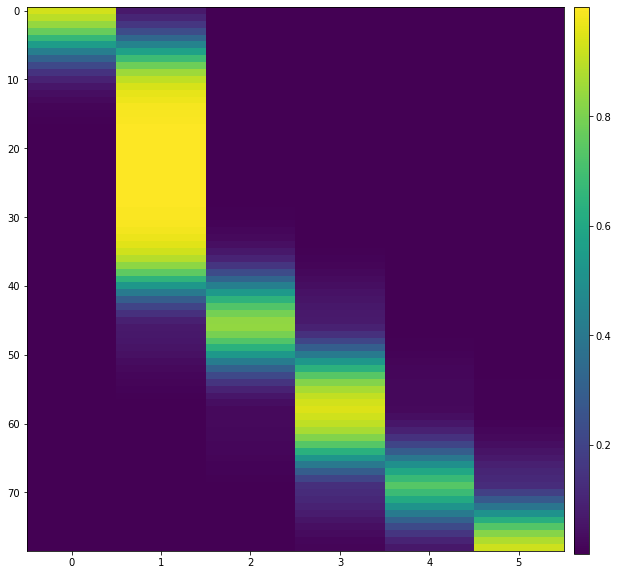

In [5]:
import matplotlib.pyplot as plt

plt.close()

fig, axis = plt.subplots(figsize=(10,10))

im = axis.imshow(ps, aspect=n_cats / n_seats)
cbar_ax = fig.add_axes([0.9, 0.12, 0.02, 0.76])
fig.colorbar(im, cax=cbar_ax)

plt.show()

### Empirical check for DPness

Now as we have trained the utility scores, we can varify that the learned solution is DP. 
For $\epsilon$-DP, we of course require 
\begin{align}
    | \log \Pr(M(C+1) = i) - \log \Pr(M(C) = i) | \leq \epsilon,
\end{align}
for counts $C$ and $C+1$ produced by neighbouring data sets. We can verify this now simply by comparing the learned log-probabilities between concecutive counts.

In [6]:
logps = get_logps(qs, eps)
max_abs_logdiff_for_count = np.max(np.array([np.abs(logps[i] - logps[i+1]) for i in range(0, n_seats)]), axis=1)
print(np.max(max_abs_logdiff_for_count) < eps)

True


## Permute and flip

In [7]:
sensitivity = jnp.max(jnp.abs(qs[:((n_seats+1)-1)]-qs[1:]))

def permute_and_flip(q, eps):
    q_star = np.max(q)
    rs = np.random.permutation(np.arange(len(q)))
    for r in rs:
        pr = np.exp(eps / (2 * sensitivity)*(q[r] - q_star))
        if np.random.rand()<pr:
            return r    

### Test at the edge

Lets compare the permute and flip and EM for reporting the count $6$, which is on the edge of two bins.

In [8]:
indx = 5

In [9]:
releases_pf_for_indx = np.array([permute_and_flip(qs[indx], eps) for i in range(10000)])

In [10]:
cats, counts_pf = np.unique(releases_pf_for_indx, return_counts=True)
freqs_pf = counts_pf / counts_pf.sum()
for cat, freq in zip(cats, freqs_pf):
    print(cat, freq)

0 0.5936
1 0.4062
3 0.0001
5 0.0001


In [11]:
probs_em_for_indx = np.exp(get_logps(qs, eps)[indx])
for cat, freq in zip(np.arange(probs_em_for_indx.shape[0]), probs_em_for_indx):
    print(cat, freq)

0 0.5510012
1 0.44838744
2 0.0003791366
3 8.098091e-05
4 6.1007515e-05
5 9.021607e-05
